# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [54]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter

### Задание 1 (3 балла)
Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

Класс DecisionTree

In [55]:
def gini(x):
    hist = np.bincount(x)
    ps = hist / len(x)
    return np.sum([p * (1 - p) for p in ps])
    
def entropy(x):
    hist = np.bincount(x)
    ps = hist / len(x)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

def gain(left_y, right_y, criterion):
    y = list(left_y) + list(right_y)
    parent_impurity = criterion(y)
    if len(left_y) == 0 or len(right_y) == 0:
        return 0
    else:
        n = len(y)
        n_l, n_r = len(left_y), len(right_y)
        im_l, im_r = criterion(left_y), criterion(right_y)
        child_impurity = (n_l / n) * im_l + (n_r / n) * im_r
        ig = parent_impurity - child_impurity
        return ig

In [56]:
class DecisionTreeNode:
    def __init__(self, split_dim=None, split_value=None, left=None, right=None, value=None, proba=None):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
        self.value = value
        self.proba = proba
        
    def is_leaf(self):
        return self.value is not None

In [57]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=100, min_samples_leaf=2, n_features=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.n_features = n_features
        self.root = None
    
    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(self.n_features, X.shape[1])
        self.root = self.make_tree(X, y)
    
    def predict_proba(self, X):
        return np.array([self.traverse_tree_proba(x, self.root) for x in X])
    
    def predict(self, X):
        #proba = self.predict_proba(X)
        #return [max(p.keys(), key=lambda k: p[k]) for p in proba]
        return np.array([self.traverse_tree(x, self.root) for x in X])
    
    def make_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth and self.max_depth is not None) or n_labels == 1 or n_samples < self.min_samples_leaf:
            leaf_value, leaf_proba = self.most_common_label(y)
            return DecisionTreeNode(value=leaf_value, proba=leaf_proba)

        feature_indices = np.random.choice(n_features, self.n_features, replace=False)

        best_feature, best_threshold = self.best_criterium(X, y, feature_indices)
        
        left_indices, right_indices = self.split(X[:, best_feature], best_threshold)
        left = self.make_tree(X[left_indices, :], y[left_indices], depth+1)
        right = self.make_tree(X[right_indices, :], y[right_indices], depth+1)
        return DecisionTreeNode(split_dim=best_feature, split_value=best_threshold, left=left, right=right)
    
    def best_criterium(self, X, y, feature_indices):
        best_gain = -1
        split_index, split_threshold = None, None
        if self.criterion == 'gini':
            for feature_index in feature_indices:
                X_column = X[:, feature_index]
                thresholds = np.unique(X_column)
                for threshold in thresholds:
                    left_indices, right_indices = self.split(X_column, threshold)
                    info_gain = gain(y[left_indices], y[right_indices], gini)
                    if info_gain > best_gain:
                        best_gain = info_gain
                        split_index = feature_index
                        split_threshold = threshold
            return split_index, split_threshold
        elif self.criterion == 'entropy':
            for feature_index in feature_indices:
                X_column = X[:, feature_index]
                thresholds = np.unique(X_column)
                for threshold in thresholds:
                    left_indices, right_indices = self.split(X_column, threshold)
                    info_gain = gain(y[left_indices], y[right_indices], entropy)
                    if info_gain > best_gain:
                        best_gain = info_gain
                        split_index = feature_index
                        split_threshold = threshold
            return split_index, split_threshold
        
    def split(self, X_column, split_threshold):
        left_indices = np.argwhere(X_column <= split_threshold).flatten()
        right_indices = np.argwhere(X_column > split_threshold).flatten()
        return left_indices, right_indices
    
    def traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value

        if x[node.split_dim] <= node.split_value:
            return self.traverse_tree(x, node.left)
        return self.traverse_tree(x, node.right)
    
    def most_common_label(self, y):
        probabilities = {}
        counter = Counter(y)
        if counter == Counter():
            return 1, probabilities
        else:
            most_common = counter.most_common(1)[0][0]
            probabilities = {k: v/sum(counter.values()) for k, v in counter.items()}
            return most_common, probabilities
        
    def traverse_tree_proba(self, x, node):
        if node.is_leaf():
            return node.proba

        if x[node.split_dim] <= node.split_value:
            return self.traverse_tree_proba(x, node.left)
        return self.traverse_tree_proba(x, node.right)

Класс RandomForest

In [58]:
class RandomForestClassifier:
    def __init__(self, criterion="gini", max_depth=100, min_samples_leaf=1, max_features="auto", n_estimators=10):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.trees = []
        self.feature_subset = []
        self.sample_subset = []
        self.train_labels = None
        self.train_samples = None
    
    def fit(self, X, y):
        self.train_labels = copy.deepcopy(y)
        self.train_samples = copy.deepcopy(X)
        n_samples = X.shape[0]
        n_features = X.shape[1]
        sampsize = int(np.round(0.632 * n_samples))
        mtry = int(np.round(np.sqrt(n_features)))
        for _ in range(self.n_estimators):
            sample_idx = np.random.randint(0, n_samples, sampsize)
            feature_idx = np.random.randint(0, n_features, mtry)
            tree = DecisionTreeClassifier(criterion=self.criterion, max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            tree.fit(X[sample_idx[:, None], feature_idx], y[sample_idx])
            self.trees.append(tree)
            self.feature_subset.append(feature_idx)
            self.sample_subset.append(sample_idx)
    
    def predict(self, X, n_classes=3):
        n_trees = len(self.trees)
        n_samples = X.shape[0]
        predictions = np.zeros([n_trees, n_samples, n_classes])
        for i in range(0, n_trees):
            P = np.zeros([n_samples, n_classes])
            P[np.arange(n_samples), self.trees[i].predict(X[:, self.feature_subset[i]])] = 1
            predictions[i, :, :] = P
        mean_predictions = np.mean(predictions, axis=0)
        classes = np.argmax(mean_predictions, axis=1)
        return mean_predictions, classes

In [60]:
def ROC_AUC(data, probabilities):
    s = sorted(list(zip(probabilities, data)), reverse=True)
    x = 1 / np.where(data == 0)[0].shape[0]
    y = 1 / np.where(data == 1)[0].shape[0]
    x_points = [0]
    y_points = [0]
    tmp_x = 0
    tmp_y = 0
    auc = 0
    for p, sample in s:
        if sample == 1:
            x_points.append(tmp_x)
            tmp_y += y
            y_points.append(tmp_y)
        else:
            y_points.append(tmp_y)
            tmp_x += x
            x_points.append(tmp_x)
            auc += x * tmp_y
    return auc, x_points, y_points

Датасет cancer

In [59]:
cancer_data = pd.read_csv('/Users/olga/Downloads/BI_ML21_HW-main-3/hw2_data/cancer.csv') 
X = cancer_data.drop('label', axis=1).values 
y = cancer_data['label'].values 
le = LabelEncoder()
y = le.fit_transform(y)
sc = StandardScaler()
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

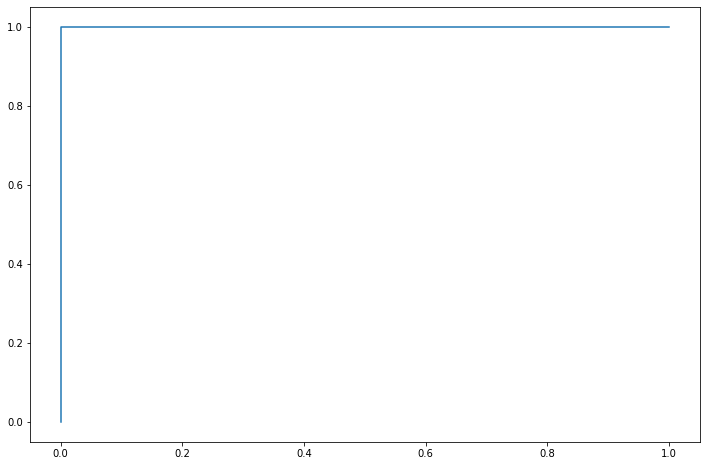

Accuracy: 0.9473684210526315
AUC: 1.0000000000000009


In [61]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
probabilities, y_pred = rfc.predict(X_test, n_classes=2)
plt.figure(figsize=(12, 8))
auc, points_x, points_y = ROC_AUC(y_pred, probabilities[:, 1])
plt.plot(points_x, points_y)
plt.show()
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'AUC: {auc}')

Датасет spam

In [62]:
spam_data = pd.read_csv('/Users/olga/Downloads/BI_ML21_HW-main-3/hw2_data/spam.csv') 
X = spam_data.drop('label', axis=1).values 
y = spam_data['label'].values 
sc = StandardScaler()
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

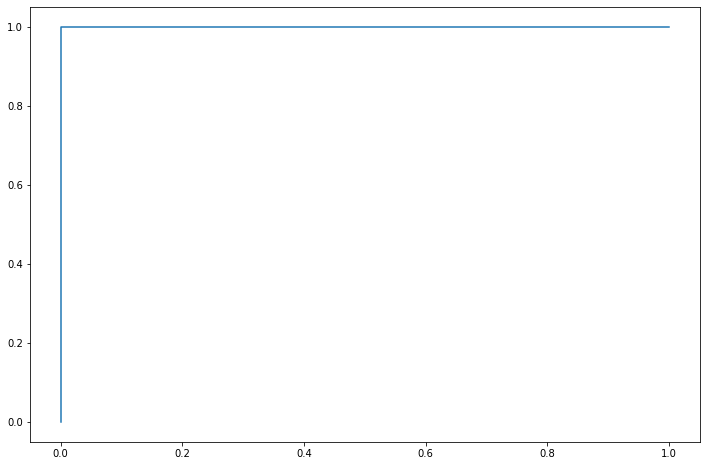

Accuracy: 0.8783930510314875
AUC: 0.9999999999999877


In [63]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
probabilities, y_pred = rfc.predict(X_test, n_classes=2)
plt.figure(figsize=(12, 8))
auc, points_x, points_y = ROC_AUC(y_pred, probabilities[:, 1])
plt.plot(points_x, points_y)
plt.show()
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'AUC: {auc}')

### Задание 3 (2 балла)
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [76]:
def cross_valid(X_train, y_train):
    n_trees_variants = [5, 10, 20, 30, 50, 100]
    max_depth_variants = [2, 3, 5, 7, 10]
    best_depth = 0
    best_number_of_trees = 0
    best_auc = 0

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    for n_trees in n_trees_variants:
        for max_depth in max_depth_variants:
            roc_auc = []
            for train_index, valid_index in kf.split(X_train):
                X_train_, X_valid = X_train[train_index], X_train[valid_index]
                y_train_, y_valid = y_train[train_index], y_train[valid_index]
                RF = RandomForestClassifier(max_depth=max_depth, n_estimators=n_trees)
                RF.fit(X_train_, y_train_)
                probabilities, classes = RF.predict(X_valid)
                auc, points_x, points_y = ROC_AUC(y_valid, probabilities[:, 1])
                roc_auc.append(auc)
            auc = np.mean(roc_auc)
            print('number of trees:', n_trees, end=' ')
            print('max_depth:', max_depth, end=' ')
            print('roc_auc:', auc)
            if best_auc < auc:
                best_auc = auc
                best_depth = max_depth
                best_number_of_trees = n_trees
    print('-------------------------')
    print(f'best auc: {best_auc}')
    print(f'best depth: {best_depth}')
    print(f'best number of trees: {best_number_of_trees}')

Датасет cancer

In [77]:
cancer_data = pd.read_csv('/Users/olga/Downloads/BI_ML21_HW-main-3/hw2_data/cancer.csv') 
X = cancer_data.drop('label', axis=1).values 
y = cancer_data['label'].values 
le = LabelEncoder()
y = le.fit_transform(y)
sc = StandardScaler()
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [78]:
cross_valid(X_train, y_train)

number of trees: 5 max_depth: 2 roc_auc: 0.994619877782583
number of trees: 5 max_depth: 3 roc_auc: 0.9859823263288444
number of trees: 5 max_depth: 5 roc_auc: 0.9909842051709374
number of trees: 5 max_depth: 7 roc_auc: 0.9874078577482368
number of trees: 5 max_depth: 10 roc_auc: 0.9862603406387848
number of trees: 10 max_depth: 2 roc_auc: 0.9847693835080313
number of trees: 10 max_depth: 3 roc_auc: 0.9908802486207442
number of trees: 10 max_depth: 5 roc_auc: 0.9903128093787961
number of trees: 10 max_depth: 7 roc_auc: 0.9916247397959035
number of trees: 10 max_depth: 10 roc_auc: 0.9921582373803568
number of trees: 20 max_depth: 2 roc_auc: 0.98849284402758
number of trees: 20 max_depth: 3 roc_auc: 0.9896964401543912
number of trees: 20 max_depth: 5 roc_auc: 0.9917181093952289
number of trees: 20 max_depth: 7 roc_auc: 0.9919918339388103
number of trees: 20 max_depth: 10 roc_auc: 0.9905589683902706
number of trees: 30 max_depth: 2 roc_auc: 0.9878421370218385
number of trees: 30 max_depth

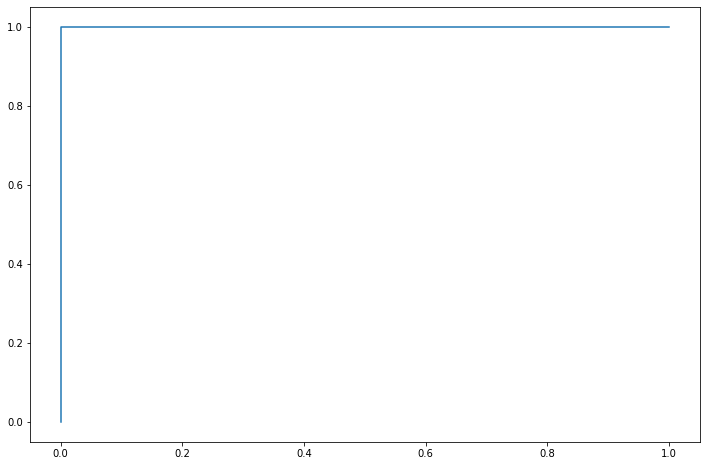

Accuracy: 0.9122807017543859
AUC: 0.9999999999999986


In [79]:
rfc = RandomForestClassifier(max_depth=2, n_estimators=5)
rfc.fit(X_train, y_train)
probabilities, y_pred = rfc.predict(X_test, n_classes=2)
plt.figure(figsize=(12, 8))
auc, points_x, points_y = ROC_AUC(y_pred, probabilities[:, 1])
plt.plot(points_x, points_y)
plt.show()
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'AUC: {auc}')

Датасет spam

In [80]:
spam_data = pd.read_csv('/Users/olga/Downloads/BI_ML21_HW-main-3/hw2_data/spam.csv') 
X = spam_data.drop('label', axis=1).values 
y = spam_data['label'].values 
sc = StandardScaler()
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [81]:
cross_valid(X_train, y_train)

number of trees: 5 max_depth: 2 roc_auc: 0.9512122339891427
number of trees: 5 max_depth: 3 roc_auc: 0.950655246421008
number of trees: 5 max_depth: 5 roc_auc: 0.9604029529334127
number of trees: 5 max_depth: 7 roc_auc: 0.9596227409770322
number of trees: 5 max_depth: 10 roc_auc: 0.9585288529218821
number of trees: 10 max_depth: 2 roc_auc: 0.946430162594894
number of trees: 10 max_depth: 3 roc_auc: 0.9614431283213241
number of trees: 10 max_depth: 5 roc_auc: 0.960979596697622
number of trees: 10 max_depth: 7 roc_auc: 0.9652182380693558
number of trees: 10 max_depth: 10 roc_auc: 0.9629783297244764
number of trees: 20 max_depth: 2 roc_auc: 0.9500167902060783
number of trees: 20 max_depth: 3 roc_auc: 0.9586643974418522
number of trees: 20 max_depth: 5 roc_auc: 0.9621468944780835
number of trees: 20 max_depth: 7 roc_auc: 0.9643435907899296
number of trees: 20 max_depth: 10 roc_auc: 0.9642375717313731
number of trees: 30 max_depth: 2 roc_auc: 0.9551901148973461
number of trees: 30 max_depth

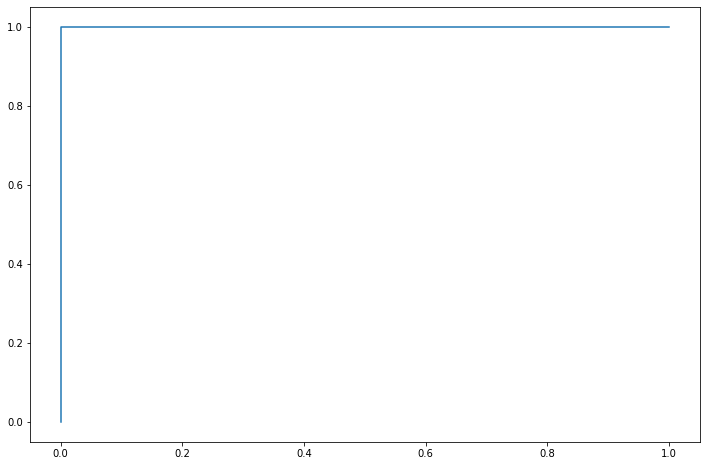

Accuracy: 0.8794788273615635
AUC: 0.9999999999999957


In [82]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=100)
rfc.fit(X_train, y_train)
probabilities, y_pred = rfc.predict(X_test, n_classes=2)
plt.figure(figsize=(12, 8))
auc, points_x, points_y = ROC_AUC(y_pred, probabilities[:, 1])
plt.plot(points_x, points_y)
plt.show()
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'AUC: {auc}')

### Задание 4 (3 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [83]:
def oob(rfc):
    sample_subset = rfc.sample_subset
    err_oob = np.zeros(len(rfc.trees))
    trees = rfc.trees
    for i in range(len(rfc.train_samples)):
        subset_indices = np.array([k for k in range(len(sample_subset)) if rfc.train_samples[i] not in sample_subset[k]], dtype='int')
        for j in subset_indices:
            vote = trees[j].predict(np.array([rfc.train_samples[i]]))
            if vote[0] != rfc.train_labels[i]:
                err_oob[j] += 1
    return err_oob

def mix_features(rfc, j):
    X = rfc.train_samples
    X_ = copy.deepcopy(X)
    mix_feature = np.random.choice(X[:, j], X.shape[0])
    X_[:, j] = mix_feature
    return X_

def oob_j(rfc, j):
    X_ = mix_features(rfc, j)
    sample_subset = rfc.sample_subset
    trees = rfc.trees
    err_oob = np.zeros(len(rfc.trees))
    for i in range(len(rfc.train_samples)):
        subset_indices = np.array([k for k in range(len(sample_subset)) if rfc.train_samples[i] not in sample_subset[k]], dtype='int')
        for j in subset_indices:
            vote = trees[j].predict([X_[i]])
            if vote[0] != rfc.train_labels[i]:
                err_oob[j] += 1
    return err_oob

def feature_importance(rfc):
    tree_importances = np.zeros((rfc.train_samples.shape[1], len(rfc.trees)))
    err_oob = oob(rfc)
    for j in range(tree_importances.shape[0]):
        err_oob_j = oob_j(rfc, j)
        tree_importances[j, :] = abs(err_oob_j - err_oob)
    forest_importances = np.mean(tree_importances, axis=1)
    return forest_importances

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [52]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)

X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)
probabilities, y_pred = rfc.predict(X)
print("Accuracy:", accuracy_score(y_pred, y))
print("Importance:", feature_importance(rfc))

Accuracy: 0.969


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Importance: [14.51 11.47  0.    0.    0.    0.  ]


Получилось, что важны признаки под номерами 0 и 1, а остальные не важны.

Проверьте, какие признаки важны для датасетов cancer и spam?

Датасет cancer

In [93]:
cancer_data = pd.read_csv('/Users/olga/Downloads/BI_ML21_HW-main-3/hw2_data/cancer.csv') 
X = cancer_data.drop('label', axis=1).values 
y = cancer_data['label'].values 
le = LabelEncoder()
y = le.fit_transform(y)
sc = StandardScaler()
X = sc.fit_transform(X)

In [94]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)
probabilities, y_pred = rfc.predict(X)
print("Accuracy:", accuracy_score(y_pred, y))
forest_importances = feature_importance(rfc)
print(np.nonzero(forest_importances))
names = np.arange(X.shape[1])
print('20 most important features:', most_important_features(forest_importances, names))

Accuracy: 1.0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


(array([0, 1, 2, 3, 4]),)
20 most important features: [ 2  3  0  4  1 28  5  6  7  8  9 10 11 12 13 29 15 16 17 18]


Датасет spam

In [97]:
spam_data = pd.read_csv('/Users/olga/Downloads/BI_ML21_HW-main-3/hw2_data/spam.csv') 
X = spam_data.drop('label', axis=1).values 
y = spam_data['label'].values 
sc = StandardScaler()
X = sc.fit_transform(X)

In [98]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)
probabilities, y_pred = rfc.predict(X)
print("Accuracy:", accuracy_score(y_pred, y))
forest_importances = feature_importance(rfc)
print(np.nonzero(forest_importances))
names = np.arange(X.shape[1])
print('20 most important features:', most_important_features(forest_importances, names))

Accuracy: 0.9517496196479026


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


(array([0, 1, 2, 3, 4, 5, 6, 7]),)
20 most important features: [ 4  6  2  5  7  0  1  3 17 25 24 23 22 21 20 19 18 13 16 15]


Для датасета cancer важными признаками стали признаки под номерами 0-4, для датасета spam - признаки с номерами 0-7.

### Задание 5 (2 балла)
В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов

In [101]:
from time import time
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#### Датасет cancer

In [102]:
cancer_data = pd.read_csv('/Users/olga/Downloads/BI_ML21_HW-main-3/hw2_data/cancer.csv') 
X = cancer_data.drop('label', axis=1).values 
y = cancer_data['label'].values 
le = LabelEncoder()
y = le.fit_transform(y)
sc = StandardScaler()
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Наш RandomForest

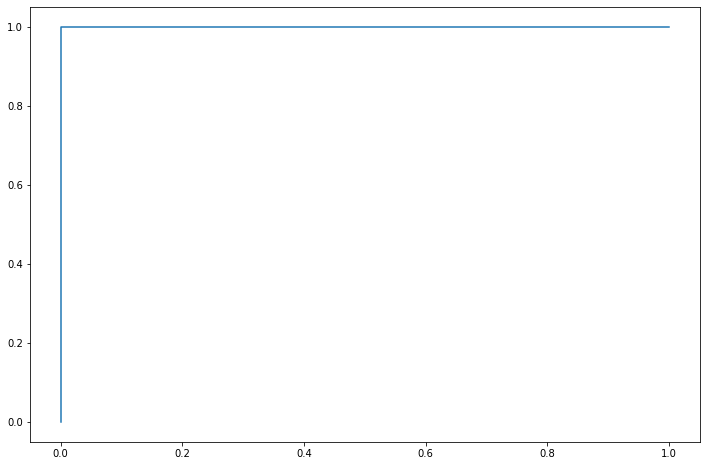

Accuracy: 0.9122807017543859
AUC: 1.0000000000000007
Training time: 1.0444860458374023


In [103]:
rfc = RandomForestClassifier(max_depth=2, n_estimators=5)
time1 = time()
rfc.fit(X_train, y_train)
time2 = time()
probabilities, y_pred = rfc.predict(X_test, n_classes=2)
plt.figure(figsize=(12, 8))
auc, points_x, points_y = ROC_AUC(y_pred, probabilities[:, 1])
plt.plot(points_x, points_y)
plt.show()
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'AUC: {auc}')
print(f'Training time: {time2 - time1}')

catboost

Learning rate set to 0.00736
0:	learn: 0.6801749	total: 61.1ms	remaining: 1m 1s
1:	learn: 0.6679720	total: 64.3ms	remaining: 32.1s
2:	learn: 0.6572003	total: 67.3ms	remaining: 22.4s
3:	learn: 0.6464915	total: 70ms	remaining: 17.4s
4:	learn: 0.6347502	total: 72.4ms	remaining: 14.4s
5:	learn: 0.6258173	total: 74.9ms	remaining: 12.4s
6:	learn: 0.6139793	total: 77.2ms	remaining: 11s
7:	learn: 0.6035186	total: 79.7ms	remaining: 9.89s
8:	learn: 0.5910718	total: 82ms	remaining: 9.03s
9:	learn: 0.5818210	total: 85.1ms	remaining: 8.42s
10:	learn: 0.5735893	total: 88.4ms	remaining: 7.95s
11:	learn: 0.5642321	total: 90.8ms	remaining: 7.48s
12:	learn: 0.5552165	total: 93.2ms	remaining: 7.07s
13:	learn: 0.5465015	total: 95.5ms	remaining: 6.72s
14:	learn: 0.5378655	total: 98ms	remaining: 6.44s
15:	learn: 0.5292541	total: 100ms	remaining: 6.17s
16:	learn: 0.5216778	total: 103ms	remaining: 5.94s
17:	learn: 0.5134620	total: 105ms	remaining: 5.74s
18:	learn: 0.5052889	total: 108ms	remaining: 5.55s
19:	l

196:	learn: 0.0879530	total: 556ms	remaining: 2.27s
197:	learn: 0.0873361	total: 559ms	remaining: 2.27s
198:	learn: 0.0869050	total: 562ms	remaining: 2.26s
199:	learn: 0.0864042	total: 566ms	remaining: 2.26s
200:	learn: 0.0860257	total: 569ms	remaining: 2.26s
201:	learn: 0.0855450	total: 572ms	remaining: 2.26s
202:	learn: 0.0849748	total: 575ms	remaining: 2.26s
203:	learn: 0.0844992	total: 579ms	remaining: 2.26s
204:	learn: 0.0841411	total: 581ms	remaining: 2.25s
205:	learn: 0.0836410	total: 583ms	remaining: 2.25s
206:	learn: 0.0831698	total: 585ms	remaining: 2.24s
207:	learn: 0.0826977	total: 587ms	remaining: 2.24s
208:	learn: 0.0823605	total: 589ms	remaining: 2.23s
209:	learn: 0.0818521	total: 592ms	remaining: 2.23s
210:	learn: 0.0814192	total: 595ms	remaining: 2.23s
211:	learn: 0.0809987	total: 597ms	remaining: 2.22s
212:	learn: 0.0805241	total: 600ms	remaining: 2.21s
213:	learn: 0.0800215	total: 602ms	remaining: 2.21s
214:	learn: 0.0795141	total: 604ms	remaining: 2.21s
215:	learn: 

355:	learn: 0.0430721	total: 928ms	remaining: 1.68s
356:	learn: 0.0429156	total: 931ms	remaining: 1.68s
357:	learn: 0.0427092	total: 934ms	remaining: 1.68s
358:	learn: 0.0425168	total: 937ms	remaining: 1.67s
359:	learn: 0.0424039	total: 940ms	remaining: 1.67s
360:	learn: 0.0422200	total: 943ms	remaining: 1.67s
361:	learn: 0.0420922	total: 946ms	remaining: 1.67s
362:	learn: 0.0419636	total: 949ms	remaining: 1.66s
363:	learn: 0.0418148	total: 951ms	remaining: 1.66s
364:	learn: 0.0417143	total: 953ms	remaining: 1.66s
365:	learn: 0.0415472	total: 955ms	remaining: 1.65s
366:	learn: 0.0414129	total: 957ms	remaining: 1.65s
367:	learn: 0.0412803	total: 960ms	remaining: 1.65s
368:	learn: 0.0411914	total: 962ms	remaining: 1.65s
369:	learn: 0.0410581	total: 965ms	remaining: 1.64s
370:	learn: 0.0408720	total: 967ms	remaining: 1.64s
371:	learn: 0.0407461	total: 969ms	remaining: 1.64s
372:	learn: 0.0406074	total: 971ms	remaining: 1.63s
373:	learn: 0.0404781	total: 973ms	remaining: 1.63s
374:	learn: 

590:	learn: 0.0217437	total: 1.49s	remaining: 1.03s
591:	learn: 0.0216832	total: 1.5s	remaining: 1.03s
592:	learn: 0.0216381	total: 1.5s	remaining: 1.03s
593:	learn: 0.0216146	total: 1.5s	remaining: 1.03s
594:	learn: 0.0215793	total: 1.5s	remaining: 1.02s
595:	learn: 0.0215240	total: 1.51s	remaining: 1.02s
596:	learn: 0.0214777	total: 1.51s	remaining: 1.02s
597:	learn: 0.0214165	total: 1.51s	remaining: 1.02s
598:	learn: 0.0213639	total: 1.52s	remaining: 1.01s
599:	learn: 0.0213129	total: 1.52s	remaining: 1.01s
600:	learn: 0.0212826	total: 1.52s	remaining: 1.01s
601:	learn: 0.0212392	total: 1.52s	remaining: 1.01s
602:	learn: 0.0211924	total: 1.52s	remaining: 1s
603:	learn: 0.0211378	total: 1.53s	remaining: 1s
604:	learn: 0.0210923	total: 1.53s	remaining: 999ms
605:	learn: 0.0210412	total: 1.53s	remaining: 996ms
606:	learn: 0.0209817	total: 1.53s	remaining: 994ms
607:	learn: 0.0209106	total: 1.54s	remaining: 991ms
608:	learn: 0.0208661	total: 1.54s	remaining: 988ms
609:	learn: 0.0208244	

770:	learn: 0.0147378	total: 2.06s	remaining: 611ms
771:	learn: 0.0147001	total: 2.06s	remaining: 609ms
772:	learn: 0.0146647	total: 2.06s	remaining: 606ms
773:	learn: 0.0146227	total: 2.07s	remaining: 603ms
774:	learn: 0.0145872	total: 2.07s	remaining: 601ms
775:	learn: 0.0145553	total: 2.07s	remaining: 598ms
776:	learn: 0.0145348	total: 2.08s	remaining: 596ms
777:	learn: 0.0145145	total: 2.08s	remaining: 593ms
778:	learn: 0.0145119	total: 2.08s	remaining: 591ms
779:	learn: 0.0144790	total: 2.08s	remaining: 588ms
780:	learn: 0.0144507	total: 2.09s	remaining: 586ms
781:	learn: 0.0144098	total: 2.09s	remaining: 583ms
782:	learn: 0.0143848	total: 2.09s	remaining: 580ms
783:	learn: 0.0143784	total: 2.1s	remaining: 577ms
784:	learn: 0.0143612	total: 2.1s	remaining: 575ms
785:	learn: 0.0143336	total: 2.1s	remaining: 572ms
786:	learn: 0.0143005	total: 2.1s	remaining: 569ms
787:	learn: 0.0142862	total: 2.1s	remaining: 566ms
788:	learn: 0.0142592	total: 2.11s	remaining: 564ms
789:	learn: 0.014

929:	learn: 0.0109930	total: 2.43s	remaining: 183ms
930:	learn: 0.0109769	total: 2.43s	remaining: 180ms
931:	learn: 0.0109568	total: 2.44s	remaining: 178ms
932:	learn: 0.0109348	total: 2.44s	remaining: 175ms
933:	learn: 0.0109238	total: 2.44s	remaining: 173ms
934:	learn: 0.0108999	total: 2.44s	remaining: 170ms
935:	learn: 0.0108969	total: 2.45s	remaining: 167ms
936:	learn: 0.0108840	total: 2.45s	remaining: 165ms
937:	learn: 0.0108579	total: 2.45s	remaining: 162ms
938:	learn: 0.0108430	total: 2.46s	remaining: 160ms
939:	learn: 0.0108143	total: 2.46s	remaining: 157ms
940:	learn: 0.0107975	total: 2.46s	remaining: 154ms
941:	learn: 0.0107841	total: 2.46s	remaining: 152ms
942:	learn: 0.0107674	total: 2.46s	remaining: 149ms
943:	learn: 0.0107564	total: 2.47s	remaining: 146ms
944:	learn: 0.0107527	total: 2.47s	remaining: 144ms
945:	learn: 0.0107503	total: 2.47s	remaining: 141ms
946:	learn: 0.0107224	total: 2.48s	remaining: 139ms
947:	learn: 0.0107032	total: 2.48s	remaining: 136ms
948:	learn: 

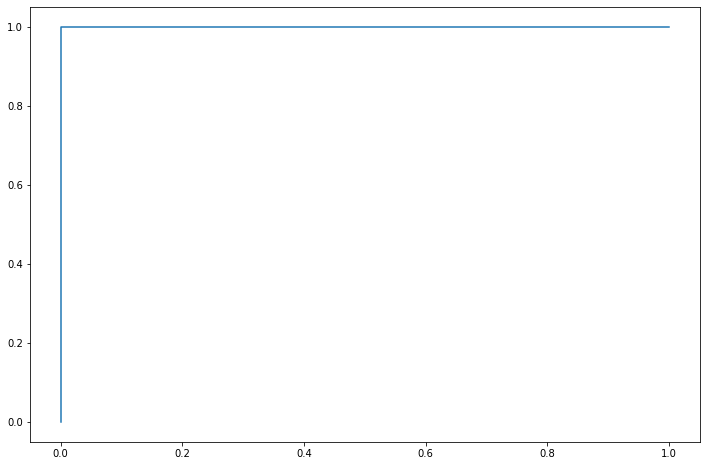

Accuracy: 0.9649122807017544
AUC: 1.0000000000000009
Training time: 2.8522250652313232


In [104]:
cbc = CatBoostClassifier()
time1 = time()
cbc.fit(X_train, y_train)
time2 = time()
probabilities = cbc.predict_proba(X_test)
y_pred = np.argmax(probabilities, axis=1)
plt.figure(figsize=(12, 8))
auc, points_x, points_y = ROC_AUC(y_pred, probabilities[:, 1])
plt.plot(points_x, points_y)
plt.show()
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'AUC: {auc}')
print(f'Training time: {time2 - time1}')

xgboost

/usr/local/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:18:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


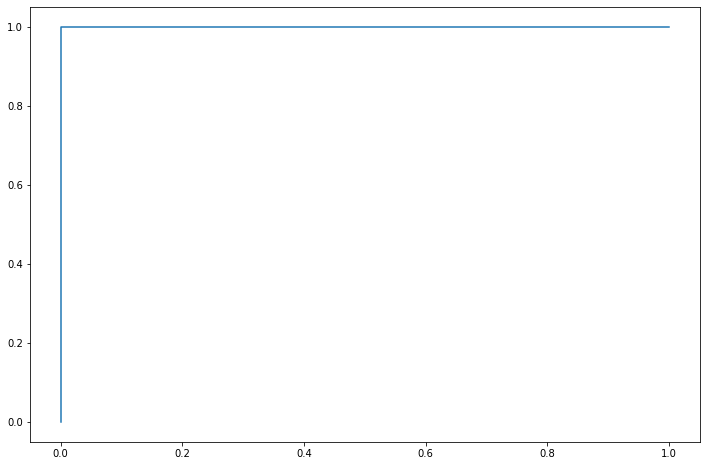

Accuracy: 0.9649122807017544
AUC: 1.0000000000000009
Training time: 0.05759716033935547


In [105]:
xgb = XGBClassifier()
time1 = time()
xgb.fit(X_train, y_train)
time2 = time()
probabilities = xgb.predict_proba(X_test)
y_pred = np.argmax(probabilities, axis=1)
plt.figure(figsize=(12, 8))
auc, points_x, points_y = ROC_AUC(y_pred, probabilities[:, 1])
plt.plot(points_x, points_y)
plt.show()
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'AUC: {auc}')
print(f'Training time: {time2 - time1}')

lightgbm

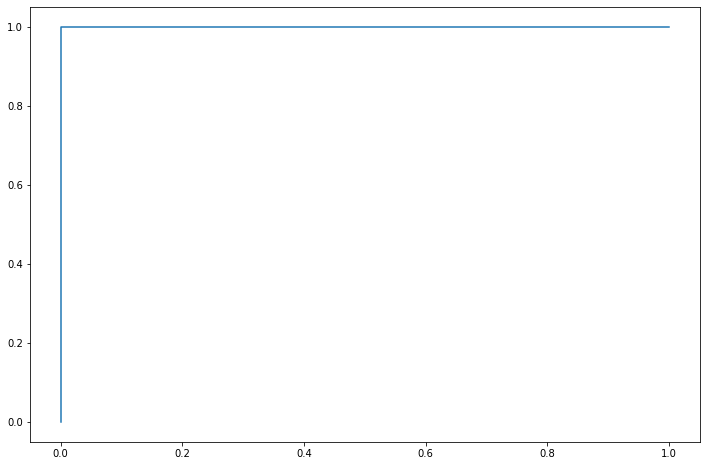

Accuracy: 0.9649122807017544
AUC: 1.0000000000000009
Training time: 0.08400082588195801


In [106]:
lgb = LGBMClassifier()
time1 = time()
lgb.fit(X_train, y_train)
time2 = time()
probabilities = lgb.predict_proba(X_test)
y_pred = np.argmax(probabilities, axis=1)
plt.figure(figsize=(12, 8))
auc, points_x, points_y = ROC_AUC(y_pred, probabilities[:, 1])
plt.plot(points_x, points_y)
plt.show()
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'AUC: {auc}')
print(f'Training time: {time2 - time1}')

#### Датасет spam

In [109]:
spam_data = pd.read_csv('/Users/olga/Downloads/BI_ML21_HW-main-3/hw2_data/spam.csv') 
X = spam_data.drop('label', axis=1).values 
y = spam_data['label'].values 
sc = StandardScaler()
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Наш RandomForest

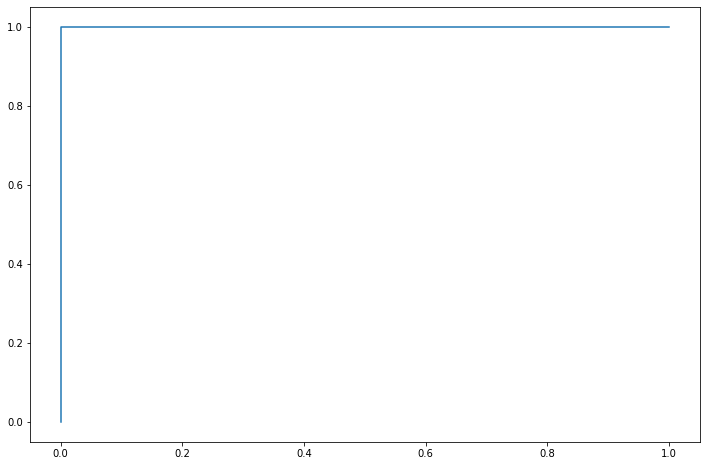

Accuracy: 0.8925081433224755
AUC: 0.9999999999999897
Training time: 444.99555587768555


In [110]:
rfc = RandomForestClassifier(n_estimators=100)
time1 = time()
rfc.fit(X_train, y_train)
time2 = time()
probabilities, y_pred = rfc.predict(X_test, n_classes=2)
plt.figure(figsize=(12, 8))
auc, points_x, points_y = ROC_AUC(y_pred, probabilities[:, 1])
plt.plot(points_x, points_y)
plt.show()
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'AUC: {auc}')
print(f'Training time: {time2 - time1}')

catboost

Learning rate set to 0.01797
0:	learn: 0.6705180	total: 7.83ms	remaining: 7.82s
1:	learn: 0.6500634	total: 12.8ms	remaining: 6.4s
2:	learn: 0.6306032	total: 16.6ms	remaining: 5.5s
3:	learn: 0.6150354	total: 20.1ms	remaining: 5.02s
4:	learn: 0.5966429	total: 24.4ms	remaining: 4.86s
5:	learn: 0.5796480	total: 30.1ms	remaining: 4.98s
6:	learn: 0.5626317	total: 33.9ms	remaining: 4.8s
7:	learn: 0.5452851	total: 38ms	remaining: 4.71s
8:	learn: 0.5302228	total: 41.7ms	remaining: 4.59s
9:	learn: 0.5177845	total: 45.8ms	remaining: 4.54s
10:	learn: 0.5044165	total: 49.5ms	remaining: 4.45s
11:	learn: 0.4898422	total: 53.3ms	remaining: 4.39s
12:	learn: 0.4775591	total: 57.2ms	remaining: 4.34s
13:	learn: 0.4663893	total: 61ms	remaining: 4.29s
14:	learn: 0.4548785	total: 64.8ms	remaining: 4.25s
15:	learn: 0.4431020	total: 68.5ms	remaining: 4.21s
16:	learn: 0.4342428	total: 72.3ms	remaining: 4.18s
17:	learn: 0.4247709	total: 76.4ms	remaining: 4.17s
18:	learn: 0.4150663	total: 80.1ms	remaining: 4.14s


164:	learn: 0.1484403	total: 775ms	remaining: 3.92s
165:	learn: 0.1481150	total: 783ms	remaining: 3.94s
166:	learn: 0.1478073	total: 790ms	remaining: 3.94s
167:	learn: 0.1475081	total: 799ms	remaining: 3.96s
168:	learn: 0.1472638	total: 806ms	remaining: 3.96s
169:	learn: 0.1470665	total: 813ms	remaining: 3.97s
170:	learn: 0.1467870	total: 821ms	remaining: 3.98s
171:	learn: 0.1464044	total: 828ms	remaining: 3.99s
172:	learn: 0.1461204	total: 836ms	remaining: 3.99s
173:	learn: 0.1458488	total: 842ms	remaining: 4s
174:	learn: 0.1455183	total: 849ms	remaining: 4s
175:	learn: 0.1453736	total: 857ms	remaining: 4.01s
176:	learn: 0.1451479	total: 864ms	remaining: 4.02s
177:	learn: 0.1447295	total: 870ms	remaining: 4.02s
178:	learn: 0.1444491	total: 874ms	remaining: 4.01s
179:	learn: 0.1443919	total: 879ms	remaining: 4s
180:	learn: 0.1441018	total: 883ms	remaining: 4s
181:	learn: 0.1437706	total: 887ms	remaining: 3.98s
182:	learn: 0.1435310	total: 891ms	remaining: 3.98s
183:	learn: 0.1431915	to

323:	learn: 0.1184593	total: 1.55s	remaining: 3.24s
324:	learn: 0.1183149	total: 1.56s	remaining: 3.24s
325:	learn: 0.1182814	total: 1.56s	remaining: 3.23s
326:	learn: 0.1181959	total: 1.57s	remaining: 3.23s
327:	learn: 0.1179930	total: 1.58s	remaining: 3.23s
328:	learn: 0.1178577	total: 1.58s	remaining: 3.23s
329:	learn: 0.1177456	total: 1.59s	remaining: 3.24s
330:	learn: 0.1176902	total: 1.6s	remaining: 3.24s
331:	learn: 0.1175892	total: 1.61s	remaining: 3.24s
332:	learn: 0.1174141	total: 1.62s	remaining: 3.24s
333:	learn: 0.1173647	total: 1.62s	remaining: 3.24s
334:	learn: 0.1171754	total: 1.63s	remaining: 3.24s
335:	learn: 0.1170109	total: 1.64s	remaining: 3.24s
336:	learn: 0.1169386	total: 1.65s	remaining: 3.24s
337:	learn: 0.1168761	total: 1.65s	remaining: 3.24s
338:	learn: 0.1167661	total: 1.66s	remaining: 3.23s
339:	learn: 0.1166933	total: 1.67s	remaining: 3.23s
340:	learn: 0.1166218	total: 1.67s	remaining: 3.23s
341:	learn: 0.1165606	total: 1.68s	remaining: 3.23s
342:	learn: 0

488:	learn: 0.1022155	total: 2.7s	remaining: 2.83s
489:	learn: 0.1021861	total: 2.71s	remaining: 2.82s
490:	learn: 0.1020924	total: 2.72s	remaining: 2.82s
491:	learn: 0.1020735	total: 2.73s	remaining: 2.81s
492:	learn: 0.1020535	total: 2.73s	remaining: 2.81s
493:	learn: 0.1019516	total: 2.74s	remaining: 2.81s
494:	learn: 0.1019318	total: 2.75s	remaining: 2.8s
495:	learn: 0.1018020	total: 2.75s	remaining: 2.8s
496:	learn: 0.1017056	total: 2.76s	remaining: 2.79s
497:	learn: 0.1016897	total: 2.77s	remaining: 2.79s
498:	learn: 0.1015875	total: 2.77s	remaining: 2.79s
499:	learn: 0.1014723	total: 2.78s	remaining: 2.78s
500:	learn: 0.1013898	total: 2.79s	remaining: 2.78s
501:	learn: 0.1013436	total: 2.79s	remaining: 2.77s
502:	learn: 0.1013310	total: 2.8s	remaining: 2.77s
503:	learn: 0.1012549	total: 2.8s	remaining: 2.76s
504:	learn: 0.1011827	total: 2.81s	remaining: 2.75s
505:	learn: 0.1011176	total: 2.81s	remaining: 2.74s
506:	learn: 0.1009878	total: 2.81s	remaining: 2.74s
507:	learn: 0.100

654:	learn: 0.0907384	total: 3.49s	remaining: 1.84s
655:	learn: 0.0906444	total: 3.5s	remaining: 1.83s
656:	learn: 0.0904772	total: 3.5s	remaining: 1.83s
657:	learn: 0.0903631	total: 3.51s	remaining: 1.82s
658:	learn: 0.0902562	total: 3.52s	remaining: 1.82s
659:	learn: 0.0901642	total: 3.53s	remaining: 1.82s
660:	learn: 0.0900482	total: 3.53s	remaining: 1.81s
661:	learn: 0.0900406	total: 3.54s	remaining: 1.81s
662:	learn: 0.0899508	total: 3.55s	remaining: 1.8s
663:	learn: 0.0898658	total: 3.56s	remaining: 1.8s
664:	learn: 0.0898560	total: 3.56s	remaining: 1.79s
665:	learn: 0.0897478	total: 3.57s	remaining: 1.79s
666:	learn: 0.0896305	total: 3.58s	remaining: 1.78s
667:	learn: 0.0895962	total: 3.58s	remaining: 1.78s
668:	learn: 0.0895240	total: 3.59s	remaining: 1.78s
669:	learn: 0.0893244	total: 3.6s	remaining: 1.77s
670:	learn: 0.0892072	total: 3.6s	remaining: 1.77s
671:	learn: 0.0891573	total: 3.61s	remaining: 1.76s
672:	learn: 0.0891481	total: 3.62s	remaining: 1.76s
673:	learn: 0.0890

814:	learn: 0.0795858	total: 4.48s	remaining: 1.02s
815:	learn: 0.0794249	total: 4.48s	remaining: 1.01s
816:	learn: 0.0794198	total: 4.49s	remaining: 1s
817:	learn: 0.0793872	total: 4.49s	remaining: 1s
818:	learn: 0.0792942	total: 4.5s	remaining: 994ms
819:	learn: 0.0792615	total: 4.5s	remaining: 988ms
820:	learn: 0.0790673	total: 4.51s	remaining: 983ms
821:	learn: 0.0790630	total: 4.51s	remaining: 977ms
822:	learn: 0.0789875	total: 4.52s	remaining: 972ms
823:	learn: 0.0789530	total: 4.52s	remaining: 966ms
824:	learn: 0.0788527	total: 4.53s	remaining: 960ms
825:	learn: 0.0788443	total: 4.53s	remaining: 954ms
826:	learn: 0.0787459	total: 4.53s	remaining: 948ms
827:	learn: 0.0786342	total: 4.54s	remaining: 943ms
828:	learn: 0.0786023	total: 4.54s	remaining: 937ms
829:	learn: 0.0785163	total: 4.54s	remaining: 931ms
830:	learn: 0.0784195	total: 4.55s	remaining: 925ms
831:	learn: 0.0783469	total: 4.55s	remaining: 919ms
832:	learn: 0.0782580	total: 4.56s	remaining: 914ms
833:	learn: 0.078195

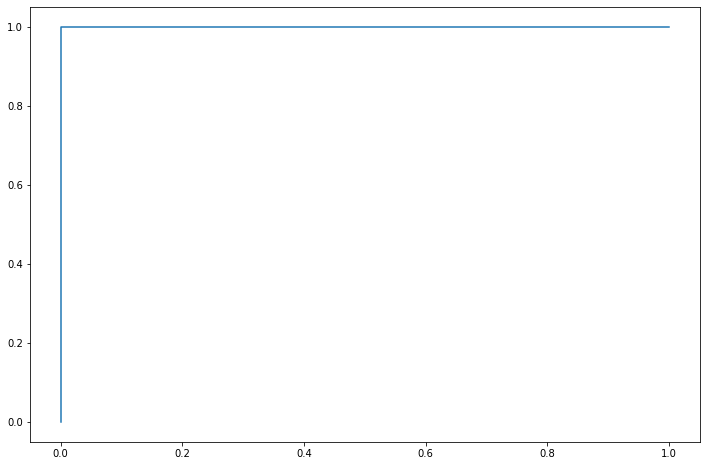

Accuracy: 0.9478827361563518
AUC: 0.9999999999999961
Training time: 5.957706928253174


In [111]:
cbc = CatBoostClassifier()
time1 = time()
cbc.fit(X_train, y_train)
time2 = time()
probabilities = cbc.predict_proba(X_test)
y_pred = np.argmax(probabilities, axis=1)
plt.figure(figsize=(12, 8))
auc, points_x, points_y = ROC_AUC(y_pred, probabilities[:, 1])
plt.plot(points_x, points_y)
plt.show()
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'AUC: {auc}')
print(f'Training time: {time2 - time1}')

xgboost

[02:32:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


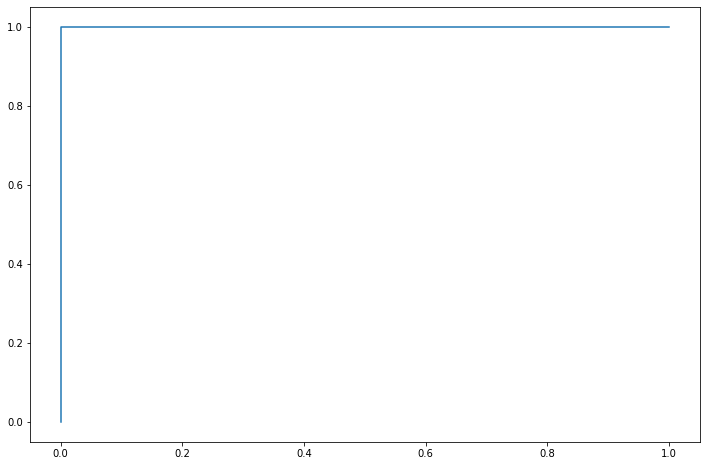

Accuracy: 0.9467969598262758
AUC: 0.9999999999999929
Training time: 0.6509580612182617


In [112]:
xgb = XGBClassifier()
time1 = time()
xgb.fit(X_train, y_train)
time2 = time()
probabilities = xgb.predict_proba(X_test)
y_pred = np.argmax(probabilities, axis=1)
plt.figure(figsize=(12, 8))
auc, points_x, points_y = ROC_AUC(y_pred, probabilities[:, 1])
plt.plot(points_x, points_y)
plt.show()
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'AUC: {auc}')
print(f'Training time: {time2 - time1}')

lightgbm

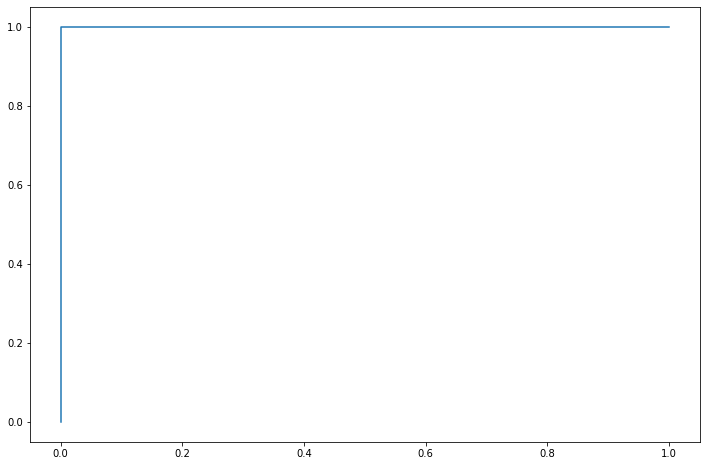

Accuracy: 0.9457111834961998
AUC: 0.9999999999999938
Training time: 0.5952939987182617


In [113]:
lgb = LGBMClassifier()
time1 = time()
lgb.fit(X_train, y_train)
time2 = time()
probabilities = lgb.predict_proba(X_test)
y_pred = np.argmax(probabilities, axis=1)
plt.figure(figsize=(12, 8))
auc, points_x, points_y = ROC_AUC(y_pred, probabilities[:, 1])
plt.plot(points_x, points_y)
plt.show()
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'AUC: {auc}')
print(f'Training time: {time2 - time1}')

Также, как и реализованный нами RandomForest, примените модели для наших датасетов.

Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)). 

Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

Датасет cancer: с задачей классификации быстрее всех справился xgboost, по метрикам качества лучшими оказались модельные классификаторы (все значения метрик одинаковы). Медленнее всех работал catboost. Так что оптимальным вариантом здесь является выбор xgboost. <br>
Датасет spam: с задачей классификации быстрее всех справился lightgbm, по метрикам качества лучшим оказался catboost. Реализованный RandomForest работал слишком долго. Поскольку для модельных классификаторов значения метрик различаются незначительно, лучшим вариантом является lightgbm. 